# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

In [76]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

Попробуем спрогнозировать динамику акций индекса Dow Jones:

In [78]:
series = pd.read_csv("weekly-closings-of-the-dowjones-.csv")['Close']

Для начала тестируем стационарность и пробуем преобразовать ряд в стационарный:

In [79]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [80]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


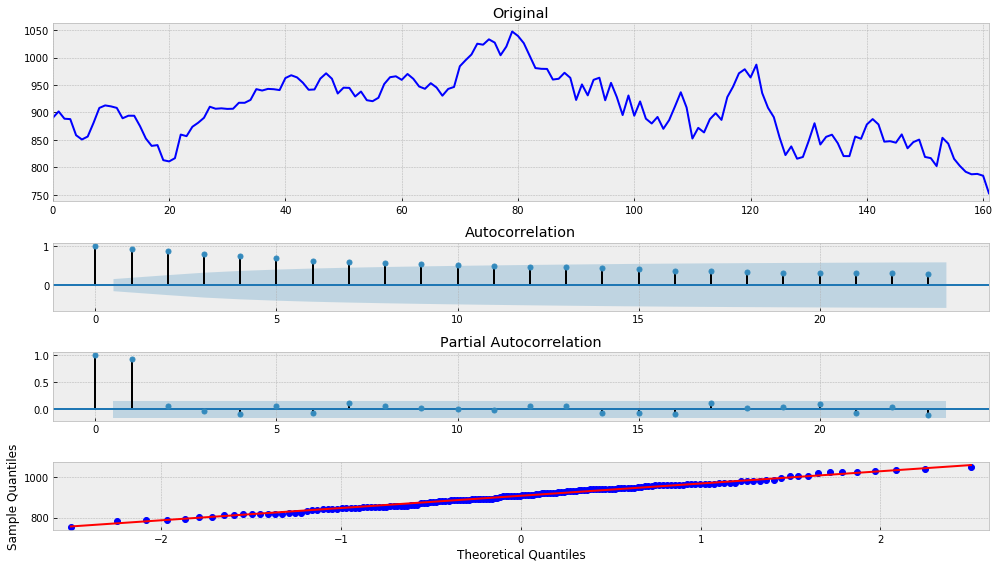

In [81]:
tsplot(series)

Очевидно, данный ряд не стационарен, что подтверждается тестом Дики-Фуллера и колеррограмой. Попробуем нормализовать дисперсию и дифференцировать:

In [82]:
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.210369
p-value                          0.669119
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


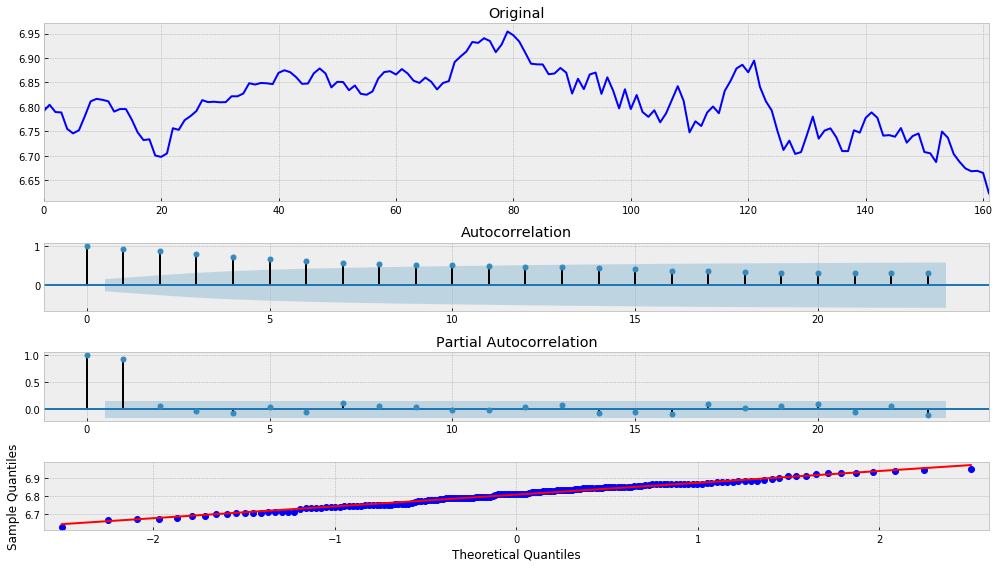

In [83]:
tsplot(series)

Как видно, нормализация дисперсии по BoxCox не сильно помогла. Попробуем теперь дифференцировать.

In [84]:
series = np.diff(series)

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


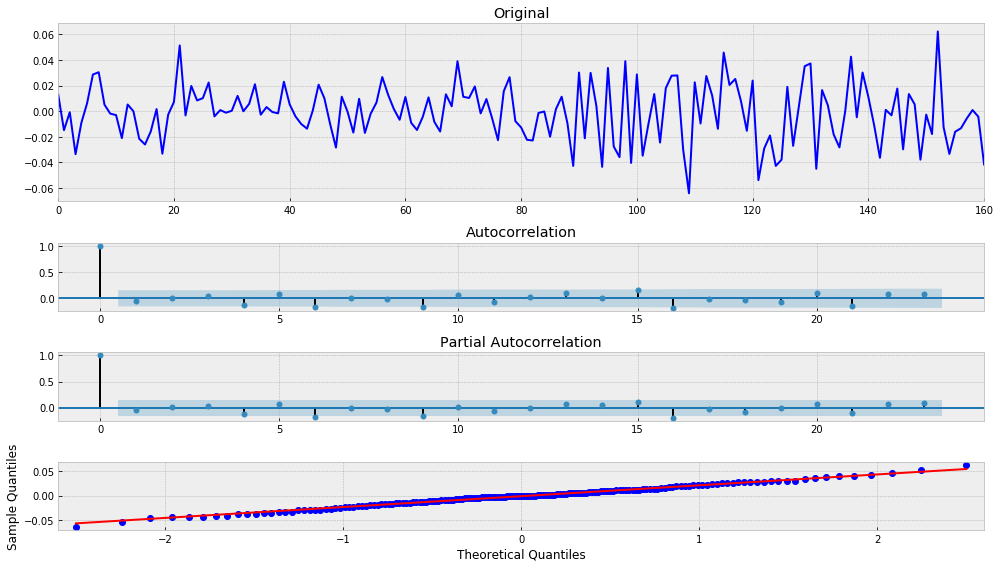

In [85]:
tsplot(series)

Ряд теперь стационарен, что подтверждается тестом Дики-Фуллера и коррелограмой.

### Переходим теперь к прогнозированию ряда с помощью модели ARIMA:

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Converg

aic: -768.58241 | order: (3, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                -1.241125e+01
p-value                        4.338574e-23
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


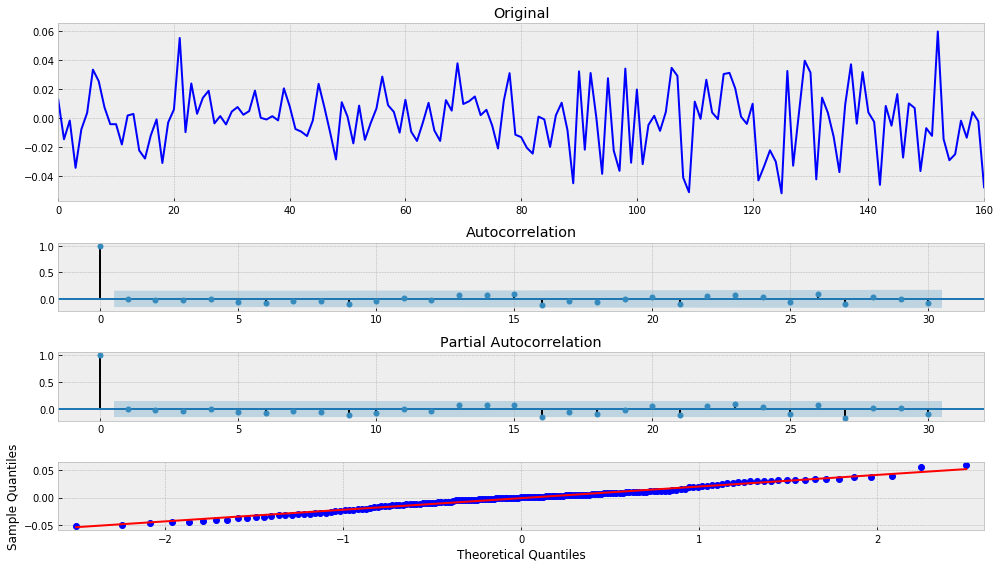

In [86]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

tsplot(best_mdl.resid, lags=30)

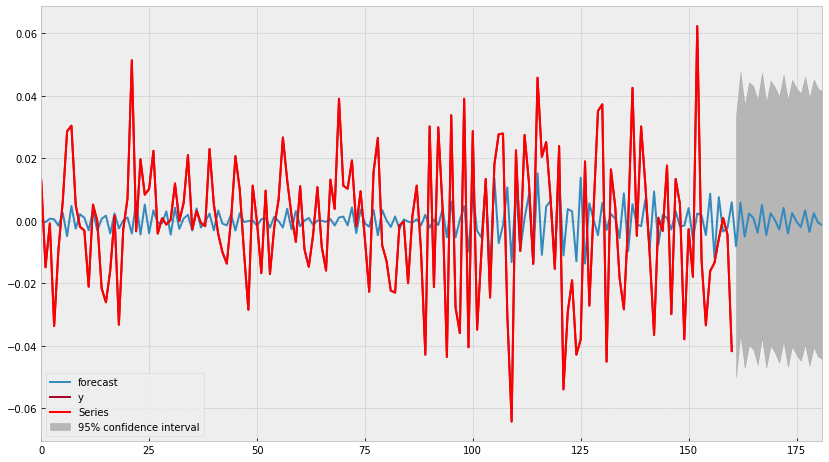

In [87]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Попробуем оценить модель, посчитав RMSE:

In [88]:
len(series)

161

In [89]:
train, test = series[:120], series[120:]

In [90]:
tmp_mdl = smt.ARIMA(train, order=(3,0,2)).fit(method='mle', trend='nc')

In [91]:
predictions = tmp_mdl.forecast(41)[0]
mse = mean_squared_error(predictions, test)
print("Root Mean Squared Error: {}".format(np.sqrt(mse)))

Root Mean Squared Error: 0.026286901353639494


In [92]:
tmp_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(3, 2)   Log Likelihood                 306.583
Method:                           mle   S.D. of innovations              0.019
Date:                Tue, 02 Jun 2020   AIC                           -601.166
Time:                        20:29:10   BIC                           -584.441
Sample:                             0   HQIC                          -594.373
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y       -1.4424      0.208     -6.949      0.000      -1.849      -1.036
ar.L2.y       -0.6946      0.238     -2.914      0.004      -1.162      -0.227
ar.L3.y        0.1353      0.134      1.011      0.314      -0.127       0.398
ma.L1.y        1.4986      0.204      7.363      0.000       1.100       1.897
ma.L2.y        0.7655      0.131      5.854      0.000       0.509       1.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8571           -0.5870j            1.0388           -0.4044
AR.2           -0.8571           +0.5870j            1.0388            0.4044
AR.3            6.8468           -0.0000j            6.8468           -0.0000
MA.1           -0.9788           -0.5901j            1.1429           -0.4136
MA.2           -0.9788           +0.5901j            1.1429            0.4136
-----------------------------------------------------------------------------
"""

### Теперь попробуем спрогнозировать ряд с помощью GARCH:

In [93]:
from arch import arch_model

In [94]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 3
o_ = 0
q_ = 2

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004889. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


Iteration:      5,   Func. Count:     76,   Neg. LLF: -392.52205457324635
Iteration:     10,   Func. Count:    135,   Neg. LLF: -394.3994652853561
Iteration:     15,   Func. Count:    187,   Neg. LLF: -395.370588961194
Iteration:     20,   Func. Count:    237,   Neg. LLF: -395.78656967847826
Iteration:     25,   Func. Count:    287,   Neg. LLF: -395.9034939668062
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -395.9073104814313
            Iterations: 28
            Function evaluations: 317
            Gradient evaluations: 28
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.006
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.006
Vol Model:                            GARCH   Log-Likelihood:                395.907
Distribution:      Standardized Student's t   AIC:                          -775.8

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


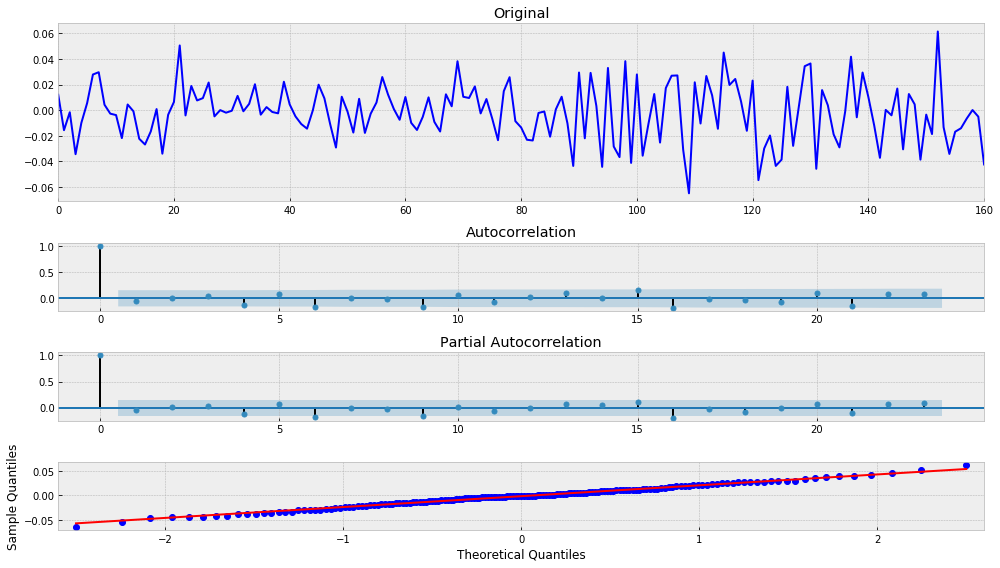

In [95]:
tsplot(res.resid)

### Наконец попробуем предсказать ряд с помощью модели ML:

In [96]:
series = pd.read_csv("weekly-closings-of-the-dowjones-.csv")

In [97]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Week"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test

In [98]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

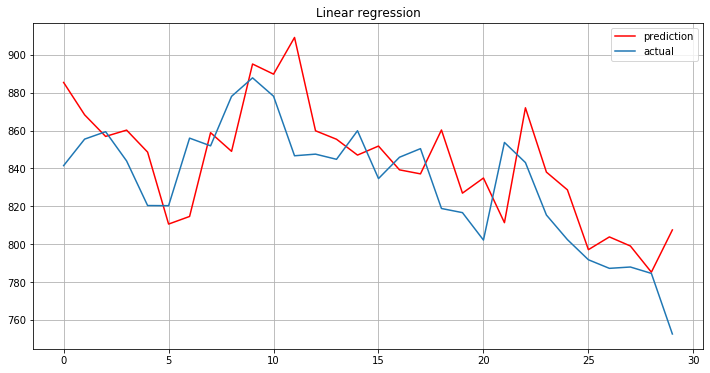

In [99]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [100]:
print("Linear Regression R^2: {}".format(lr.score(X_test, y_test)))

Linear Regression R^2: 0.2793628479305774


Модель демонстрирует низкую точность. Попробуем что-нибудь "потяжелее" из арсенала ML:

In [101]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [102]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [103]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [104]:
prediction = reg.predict(X_test)

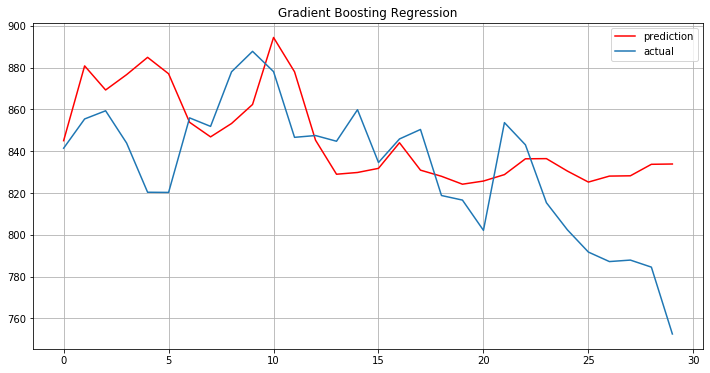

In [105]:
plt.figure(figsize=(12, 6))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Gradient Boosting Regression")
plt.grid(True);

In [106]:
print("Gradiet Boosting Regression R^2: {}".format(reg.score(X_test, y_test)))

Gradiet Boosting Regression R^2: -0.004358140699161073


Однако обычная линейная регрессия справилась с задачей лучше судя из оценки точности модели.